# **Applying SMOTE and Bootstrapping**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# Load your dataset from GCS

df = spark.read.csv("gs://dataproc-staging-europe-west2-145363193623-d10gb2xz/creditcard_2013.csv", header=True, inferSchema=True)

# Define the fractions for stratified sampling (e.g., 80% for training, 20% for testing)
fractions = {0: 0.8, 1: 0.8}  # Assuming 0 and 1 are the possible classes

# Step 1: Stratified sampling
train_data_stratified = df.sampleBy("Class", fractions, seed=42)
# To get the test data, subtract the train data from the full dataset
test_data_stratified = df.subtract(train_data_stratified)

# Optional: Check the count of the stratified splits
print("Training Data Count (Stratified):", train_data_stratified.count())
print("Test Data Count (Stratified):", test_data_stratified.count())


Training Data Count (Stratified): 227834


25/04/30 19:46:20 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Test Data Count (Stratified): 56624


In [ ]:
df.count()

284807

In [ ]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Convert Spark DataFrame to Pandas for using imbalanced-learn library
train_data_pd = train_data_stratified.toPandas()

# Assuming the target variable is 'label' and features are in other columns
X_train = train_data_pd.drop('Class', axis=1)
y_train = train_data_pd['Class']

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Convert back to Spark DataFrame
train_data_smote = pd.DataFrame(X_res, columns=X_train.columns)
train_data_smote['Class'] = y_res
train_data_smote_spark = spark.createDataFrame(train_data_smote)


In [ ]:
from pyspark.sql.functions import col, round

# Get total count
total_count = train_data_smote_spark.count()

# Get class counts with percentages
percentage_df = (
    train_data_smote_spark
    .groupBy("Class")
    .count()
    .withColumn("percentage", round((col("count") / total_count) * 100, 2))
)

percentage_df.show()




25/04/30 19:47:39 WARN TaskSetManager: Stage 23 contains a task of very large size (30540 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 19:47:43 WARN TaskSetManager: Stage 26 contains a task of very large size (30540 KiB). The maximum recommended task size is 1000 KiB.


+-----+------+----------+
|Class| count|percentage|
+-----+------+----------+
|    1|113743|     33.33|
|    0|227487|     66.67|
+-----+------+----------+



In [ ]:
from pyspark.sql.functions import randn, col
from pyspark.sql import functions as F

# Step 1: Separate by class
class_0 = train_data_smote_spark.filter(col("Class") == 0)
class_1 = train_data_smote_spark.filter(col("Class") == 1)

# Step 2: Bootstrap (sample with replacement)
bootstrapped_0 = class_0.sample(withReplacement=True, fraction=3_000_000 / class_0.count())
bootstrapped_1 = class_1.sample(withReplacement=True, fraction=1_000_000 / class_1.count())

# Step 3: Add jitter to numeric columns (example for "Amount" and "V1")
# You can expand this for all features (except "Class")
numeric_cols = [col_name for col_name, dtype in train_data_smote_spark.dtypes if dtype in ("double", "int") and col_name != "Class"]

# Loop through each numeric column
for col_name in numeric_cols:
    # Calculate the standard deviation for the current column
    stddev_value = train_data_smote_spark.select(F.stddev(col(col_name))).collect()[0][0]

    # Apply jitter to the columns based on the standard deviation
    bootstrapped_0 = bootstrapped_0.withColumn(col_name, col(col_name) + (F.randn() * stddev_value))
    bootstrapped_1 = bootstrapped_1.withColumn(col_name, col(col_name) + (F.randn() * stddev_value))

# Step 4: Union the resampled datasets
final_bootstrapped_df = bootstrapped_0.union(bootstrapped_1)

# Optional: Check size and distribution
print("Total rows:", final_bootstrapped_df.count())
final_bootstrapped_df.groupBy("Class").count().show()


25/04/30 19:47:47 WARN TaskSetManager: Stage 29 contains a task of very large size (30540 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 19:47:50 WARN TaskSetManager: Stage 32 contains a task of very large size (30540 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 19:47:52 WARN TaskSetManager: Stage 35 contains a task of very large size (30540 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 19:47:54 WARN TaskSetManager: Stage 38 contains a task of very large size (30540 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 19:47:56 WARN TaskSetManager: Stage 41 contains a task of very large size (30540 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 19:47:59 WARN TaskSetManager: Stage 44 contains a task of very large size (30540 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 19:48:01 WARN TaskSetManager: Stage 47 contains a task of very large size (30540 KiB). The maximum recommended task size is 1000 KiB.

Total rows: 3999559


25/04/30 19:49:03 WARN TaskSetManager: Stage 128 contains a task of very large size (30540 KiB). The maximum recommended task size is 1000 KiB.


+-----+-------+
|Class|  count|
+-----+-------+
|    0|2998703|
|    1|1000856|
+-----+-------+



In [ ]:
# Define the GCS path where you want to save the file
gcs_path = "gs://dataproc-staging-europe-west2-145363193623-d10gb2xz/final_training_data.csv"

# Save the DataFrame to GCS in CSV format
final_bootstrapped_df.coalesce(1).write.option("header", "true").csv(gcs_path)


25/04/30 19:51:55 WARN TaskSetManager: Stage 131 contains a task of very large size (91669 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
gcs_path = "gs://dataproc-staging-europe-west2-145363193623-d10gb2xz/train_smote_df.csv"

# Save the DataFrame to GCS in CSV format
train_data_smote_spark.coalesce(1).write.option("header", "true").csv(gcs_path)

25/04/30 19:53:12 WARN TaskSetManager: Stage 132 contains a task of very large size (91668 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
gcs_path = "gs://dataproc-staging-europe-west2-145363193623-d10gb2xz/test_data.csv"

# Save the DataFrame to GCS in CSV format
test_data_stratified.coalesce(1).write.option("header", "true").csv(gcs_path)

# **SMOTE CHECK**

## 0. Setup

In [ ]:
!pip3 install scipy
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install scikit-learn
!pip3 install imbalanced-learn
!pip3 install numpy pandas
!pip3 install jinja2
!pip3 install tabulate

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

## 1. Read in data

In [ ]:
file_path = "/content/creditcard_2013.csv"
orig = pd.read_csv(file_path)

orig = orig.sort_values("Time").reset_index(drop=True)

display(orig.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. Split data and oversample fraud cases using SMOTE

Here, we carve out 80% of the original data for training and hold 20% back for testing, making sure each split keeps the same tiny fraud‐to‐non‐fraud ratio as the full set.

Then, we apply SMOTE (Synthetic Minority Over‐sampling Technique). SMOTE looks at the real fraud cases in `X_train`, `y_train`, and creates new synthetic fraud examples by interpolating between each fraud point and one of its nearest‐neighbor frauds in feature space.

* We set `sampling_strategy=0.5`, which means “generate enough fraud points so that fraud cases are 50% as numerous as non‐fraud cases” in the training set.
* This upsamples the minority class (fraud) without touching the non‐fraud rows.

### WARNING
We should never apply SMOTE to the test data. The test set must remain a genuine, untouched sample of real transactions so our evaluation (AUC, recall, etc.) reflects true, rare‐event performance. By restricting SMOTE to the training partition, we allow the model to learn from a balanced fraud/non‐fraud mix, while preserving an honest test scenario at the real ~0.17 % fraud rate.

In [ ]:
# 1. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    orig.drop(columns='Class'),
    orig['Class'],
    stratify=orig['Class'],
    test_size=0.2,
    random_state=42
)

X_train_orig = X_train.copy()
y_train_orig = y_train.copy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 2. Train on original data BEFORE SMOTE
clf_orig = RandomForestClassifier()
clf_orig.fit(X_train, y_train)
y_pred_orig = clf_orig.predict(X_test)
print("Before SMOTE:")
print(classification_report(y_test, y_pred_orig))
print("AUC:", roc_auc_score(y_test, clf_orig.predict_proba(X_test)[:, 1]))

Before SMOTE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.82      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

AUC: 0.9577688225684196


In [ ]:
# 3. Apply SMOTE: synthesize fraud until fraud = 50% of non-fraud
smote = SMOTE(sampling_strategy=0.33, k_neighbors=2, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Used k_neighbors=2 because SMOTE otherwise assumes it to be 5.
Using an even lower sampling_strategy=0.2 reduces how many synthetic frauds are generated → less risk of overlapping with legit class.



In [ ]:
# 4. Train on SMOTE-augmented data
clf_smote = RandomForestClassifier()
clf_smote.fit(X_train_res, y_train_res)
y_pred_smote = clf_smote.predict(X_test)
print("After SMOTE:")
print(classification_report(y_test, y_pred_smote))
print("AUC:", roc_auc_score(y_test, clf_smote.predict_proba(X_test)[:, 1]))

After SMOTE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

AUC: 0.9654925859623534


SMOTE helped model generalize slightly better, especially in identifying fraud.

The AUC improvement suggests the model's confidence in ranking fraud vs. non-fraud has improved.

## 3. Visualisation check

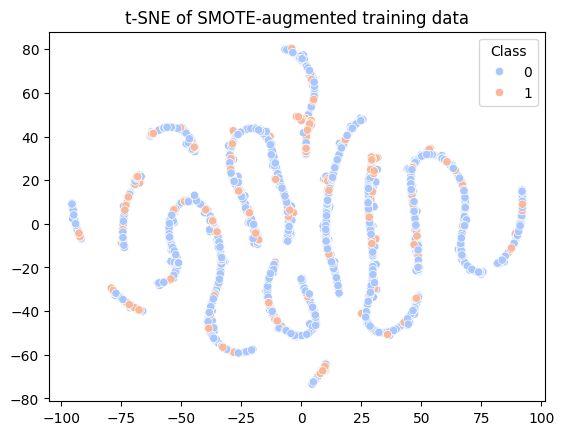

In [ ]:
from sklearn.manifold import TSNE

# Downsample non-fraud for clearer visuals if dataset is large
sample_size = 5000
X_vis = X_train_res.sample(sample_size, random_state=42)
y_vis = y_train_res.loc[X_vis.index]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_vis)

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_vis, palette='coolwarm')
plt.title("t-SNE of SMOTE-augmented training data")
plt.show()

 Since the red points (fraud class 1) are intermixed but sparse among the blue (non-fraud 0) they seem well-distributed and aren’t completely overlapping with the majority class. Therefore, using SMOTE helps.

## 4. Breakdown of the original training set, the training set with SMOTE, and the test set

In [ ]:
from IPython.display import Markdown

# 1. Original train set (before SMOTE)
orig_train_counts = pd.Series(y_train).value_counts().rename_axis('Class').reset_index(name='count')
orig_train_counts['pct'] = orig_train_counts['count'] / orig_train_counts['count'].sum()

# 2. SMOTE-augmented train set
smote_train_counts = pd.Series(y_train_res).value_counts().rename_axis('Class').reset_index(name='count')
smote_train_counts['pct'] = smote_train_counts['count'] / smote_train_counts['count'].sum()

# 3. Test set
test_counts = pd.Series(y_test).value_counts().rename_axis('Class').reset_index(name='count')
test_counts['pct'] = test_counts['count'] / test_counts['count'].sum()

In [ ]:
print("******************* ORIGINAL TRAIN SET *******************")
orig_train_counts

******************* ORIGINAL TRAIN SET *******************


,Class,count,pct
0,0,227451,0.998271
1,1,394,0.001729


In [ ]:
print("******************* SMOTE TRAIN SET *******************")
smote_train_counts

******************* SMOTE TRAIN SET *******************


,Class,count,pct
0,0,227451,0.751882
1,1,75058,0.248118


In [ ]:
print("******************* TEST SET *******************")
test_counts

******************* TEST SET *******************


,Class,count,pct
0,0,56864,0.99828
1,1,98,0.00172


In [ ]:
# Calculate how much SMOTE increased the training set
orig_train_size  = X_train.shape[0]
smote_train_size = X_train_res.shape[0]

increase_rows = smote_train_size - orig_train_size
increase_pct  = increase_rows / orig_train_size * 100

print(f"Original train size: {orig_train_size:,} rows")
print(f"SMOTE train size:    {smote_train_size:,} rows")
print(f"Increase:            {increase_rows:,} rows ({increase_pct:.1f}% increase)")

# Compute total sizes before and after SMOTE
orig_total   = orig.shape[0]
new_total    = X_train_res.shape[0] + X_test.shape[0]
increase     = new_total - orig_total
increase_pct = increase / orig_total * 100

print(f"Original total rows:    {orig_total:,}")
print(f"New total rows (train+test): {new_total:,}")
print(f"Overall increase:       {increase:,} rows ({increase_pct:.1f}% increase)")

Original train size: 227,845 rows
SMOTE train size:    302,509 rows
Increase:            74,664 rows (32.8% increase)
Original total rows:    284,807
New total rows (train+test): 359,471
Overall increase:       74,664 rows (26.2% increase)


## 5. Save data

In [ ]:
train_df = X_train_res.copy()
train_df['Class'] = y_train_res.values
train_df['split'] = 'train'

# 2. Assemble the test DataFrame
test_df = X_test.copy().reset_index(drop=True)
test_df['Class'] = y_test.reset_index(drop=True).values
test_df['split'] = 'test'

# 3. Save to CSV files
train_df.to_csv("creditcard_2013_smote_train.csv", index=False)
test_df .to_csv("creditcard_2013_test.csv",       index=False)

print("Saved train set to creditcard_2013_smote_train.csv")
print("Saved test  set to creditcard_2013_test.csv")

print(test_df)
train_df

Saved train set to creditcard_2013_smote_train.csv
Saved test  set to creditcard_2013_test.csv
           Time        V1        V2        V3        V4        V5        V6  \
0      160760.0  1.425056 -0.775905 -2.079161  0.768237 -0.027404 -1.264479   
1       19847.0 -2.829816 -2.765149  2.537793 -1.074580  2.842559 -2.153536   
2       88326.0 -3.576495  2.318422  1.306985  3.263665  1.127818  2.865246   
3      141734.0 -2.185458  0.080080 -2.369312 -0.586453 -1.875619  2.613314   
4       38741.0  1.209965  1.384303 -1.343531  1.763636  0.662351 -2.113384   
...         ...       ...       ...       ...       ...       ...       ...   
56957   46329.0 -0.863057  0.225429  2.458855  0.613099  0.067149  1.716173   
56958  126310.0  1.690884 -0.354174  1.360797  4.324395 -1.144073  1.371338   
56959  166070.0 -1.047727  0.685141  0.195457 -3.583402  0.082922 -0.444060   
56960  163789.0 -0.554484 -0.083299  2.484448  1.094489 -0.347074  1.154296   
56961   51060.0  1.228059 -0.603264 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,split
0,161919.000000,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,...,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.320000,0,train
1,124477.000000,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,...,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.990000,0,train
2,41191.000000,-1.178424,1.339908,1.097119,-0.107064,-0.719218,-0.740676,0.215229,0.543623,-0.336232,...,-0.607454,0.110262,0.467295,-0.234883,0.042543,0.112726,0.096888,24.990000,0,train
3,132624.000000,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,...,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,6.100000,0,train
4,59359.000000,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,...,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,86.100000,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302504,153854.432984,-0.296178,3.284669,-5.286731,5.086397,1.293403,-2.245106,-1.036463,0.625754,-3.275759,...,-0.305919,-0.087662,-0.595313,-0.461514,-0.017200,0.491830,0.283577,9.267786,1,train
302505,64606.107578,-3.605736,-1.174659,-2.472287,4.592226,-1.177838,-0.132905,-1.581855,0.577491,-1.627867,...,0.065661,-1.989606,-0.015036,-0.353216,0.170118,0.888066,-0.825041,343.565606,1,train
302506,139107.838830,-4.608574,-3.725217,-0.122183,5.102461,5.130588,0.574424,-1.006474,-0.560937,-0.482691,...,1.665498,0.133287,-0.709617,-0.425733,0.567370,-0.397173,0.724329,21.281377,1,train
302507,91326.188023,0.276352,1.596973,-3.045743,1.625431,1.058831,-0.366799,-1.158602,-1.348159,1.228455,...,-0.128195,-0.157964,-0.175438,0.290178,-0.353901,0.175890,0.078306,17.635591,1,train


### Data Balancing Takeaways

- **Original train set** was extremely skewed: only 0.17 % fraud (394 fraud vs. 227,451 non-fraud).  
- **After SMOTE** (fraud = 50% of non-fraud), the training mix became 33% fraud (113,725 fraud vs. 227,451 non-fraud). This gives the model far more positive examples to learn from without touching non-fraud.  
- **Test set** remains untouched at 0.17% fraud (98 fraud vs. 56,864 non-fraud), so our evaluation still reflects the true rarity of fraud.  

By oversampling fraud only in the training partition, we ensure the model sees enough fraud examples to build a good decision boundary, while preserving a realistic, imbalanced test set for honest performance measurement.